In [13]:
from tensorflow.keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.applications import ResNet50

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import tensorflow as tf
import random as rnd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from numpy import expand_dims

import os
import requests
import zipfile
import glob


from os import listdir
from os.path import isdir, isfile, join

In [2]:
def plot_augimages(paths, datagen):
### visualize augmented images generated using a Keras ImageDataGenerator ###
    plt.figure(figsize = (14,28))
    plt.suptitle('Augmented Images')

    midx = 0 # matplotlib index
    for path in paths:
        data = Image.open(path)
        data = data.resize((224,224))
        ''' add an extra dimension to the data array.
        This step is often required to make the image compatible with the batch processing
        expected by many deep learning models. The expand_dims function adds an additional
        dimension at the beginning, effectively creating a batch of size 1 containing
        the resized image.'''
        samples = expand_dims(data, 0)
        '''This line sets up an iterator (it) using a Keras ImageDataGenerator (datagen).
        The iterator is configured to generate batches of data from the samples array,
        with each batch containing one image (batch_size=1).
        This iterator can be used to generate augmented versions of the image during training.'''
        it = datagen.flow(samples, batch_size=1)

        # Show Original Image
        plt.subplot(10,5, midx+1)
        plt.imshow(data)
        plt.axis('off')

        # Show Augmented Images
        for idx, i in enumerate(range(4)):
            midx += 1
            plt.subplot(10,5, midx+1)

            batch = it.next()
            image = batch[0].astype('uint8') # extracts the image data from the batch
            plt.imshow(image)
            plt.axis('off')
        midx += 1

    plt.tight_layout()
    plt.show()

# Import data

In [3]:
target_directory = 'data/'

zip_url = 'https://www.muratkoklu.com/datasets/vtdhnd10.php'

os.makedirs(target_directory, exist_ok=True)
response = requests.get(zip_url)
zip_path = os.path.join(target_directory, 'data.zip')

with open(zip_path, 'wb') as zip_file:
    zip_file.write(response.content)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_directory)

In [4]:
data_dir = os.path.join(target_directory, 'Grapevine_Leaves_Image_Dataset/*')

data = []
labels = []


for class_folder in glob.glob(data_dir):
    label = os.path.basename(class_folder)

    for image_path in glob.glob(os.path.join(class_folder, '*.png')):
        labels.append(label)
        data.append(image_path)

In [5]:
print(len(data))

500


# Split the data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# Generators

In [7]:
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

train_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        pd.DataFrame({'path': X_train, 'class': y_train}),
        x_col='path',
        y_col='class',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        pd.DataFrame({'path': X_val, 'class': y_val}),  # This is the source directory for training images
        x_col='path',
        y_col='class',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.


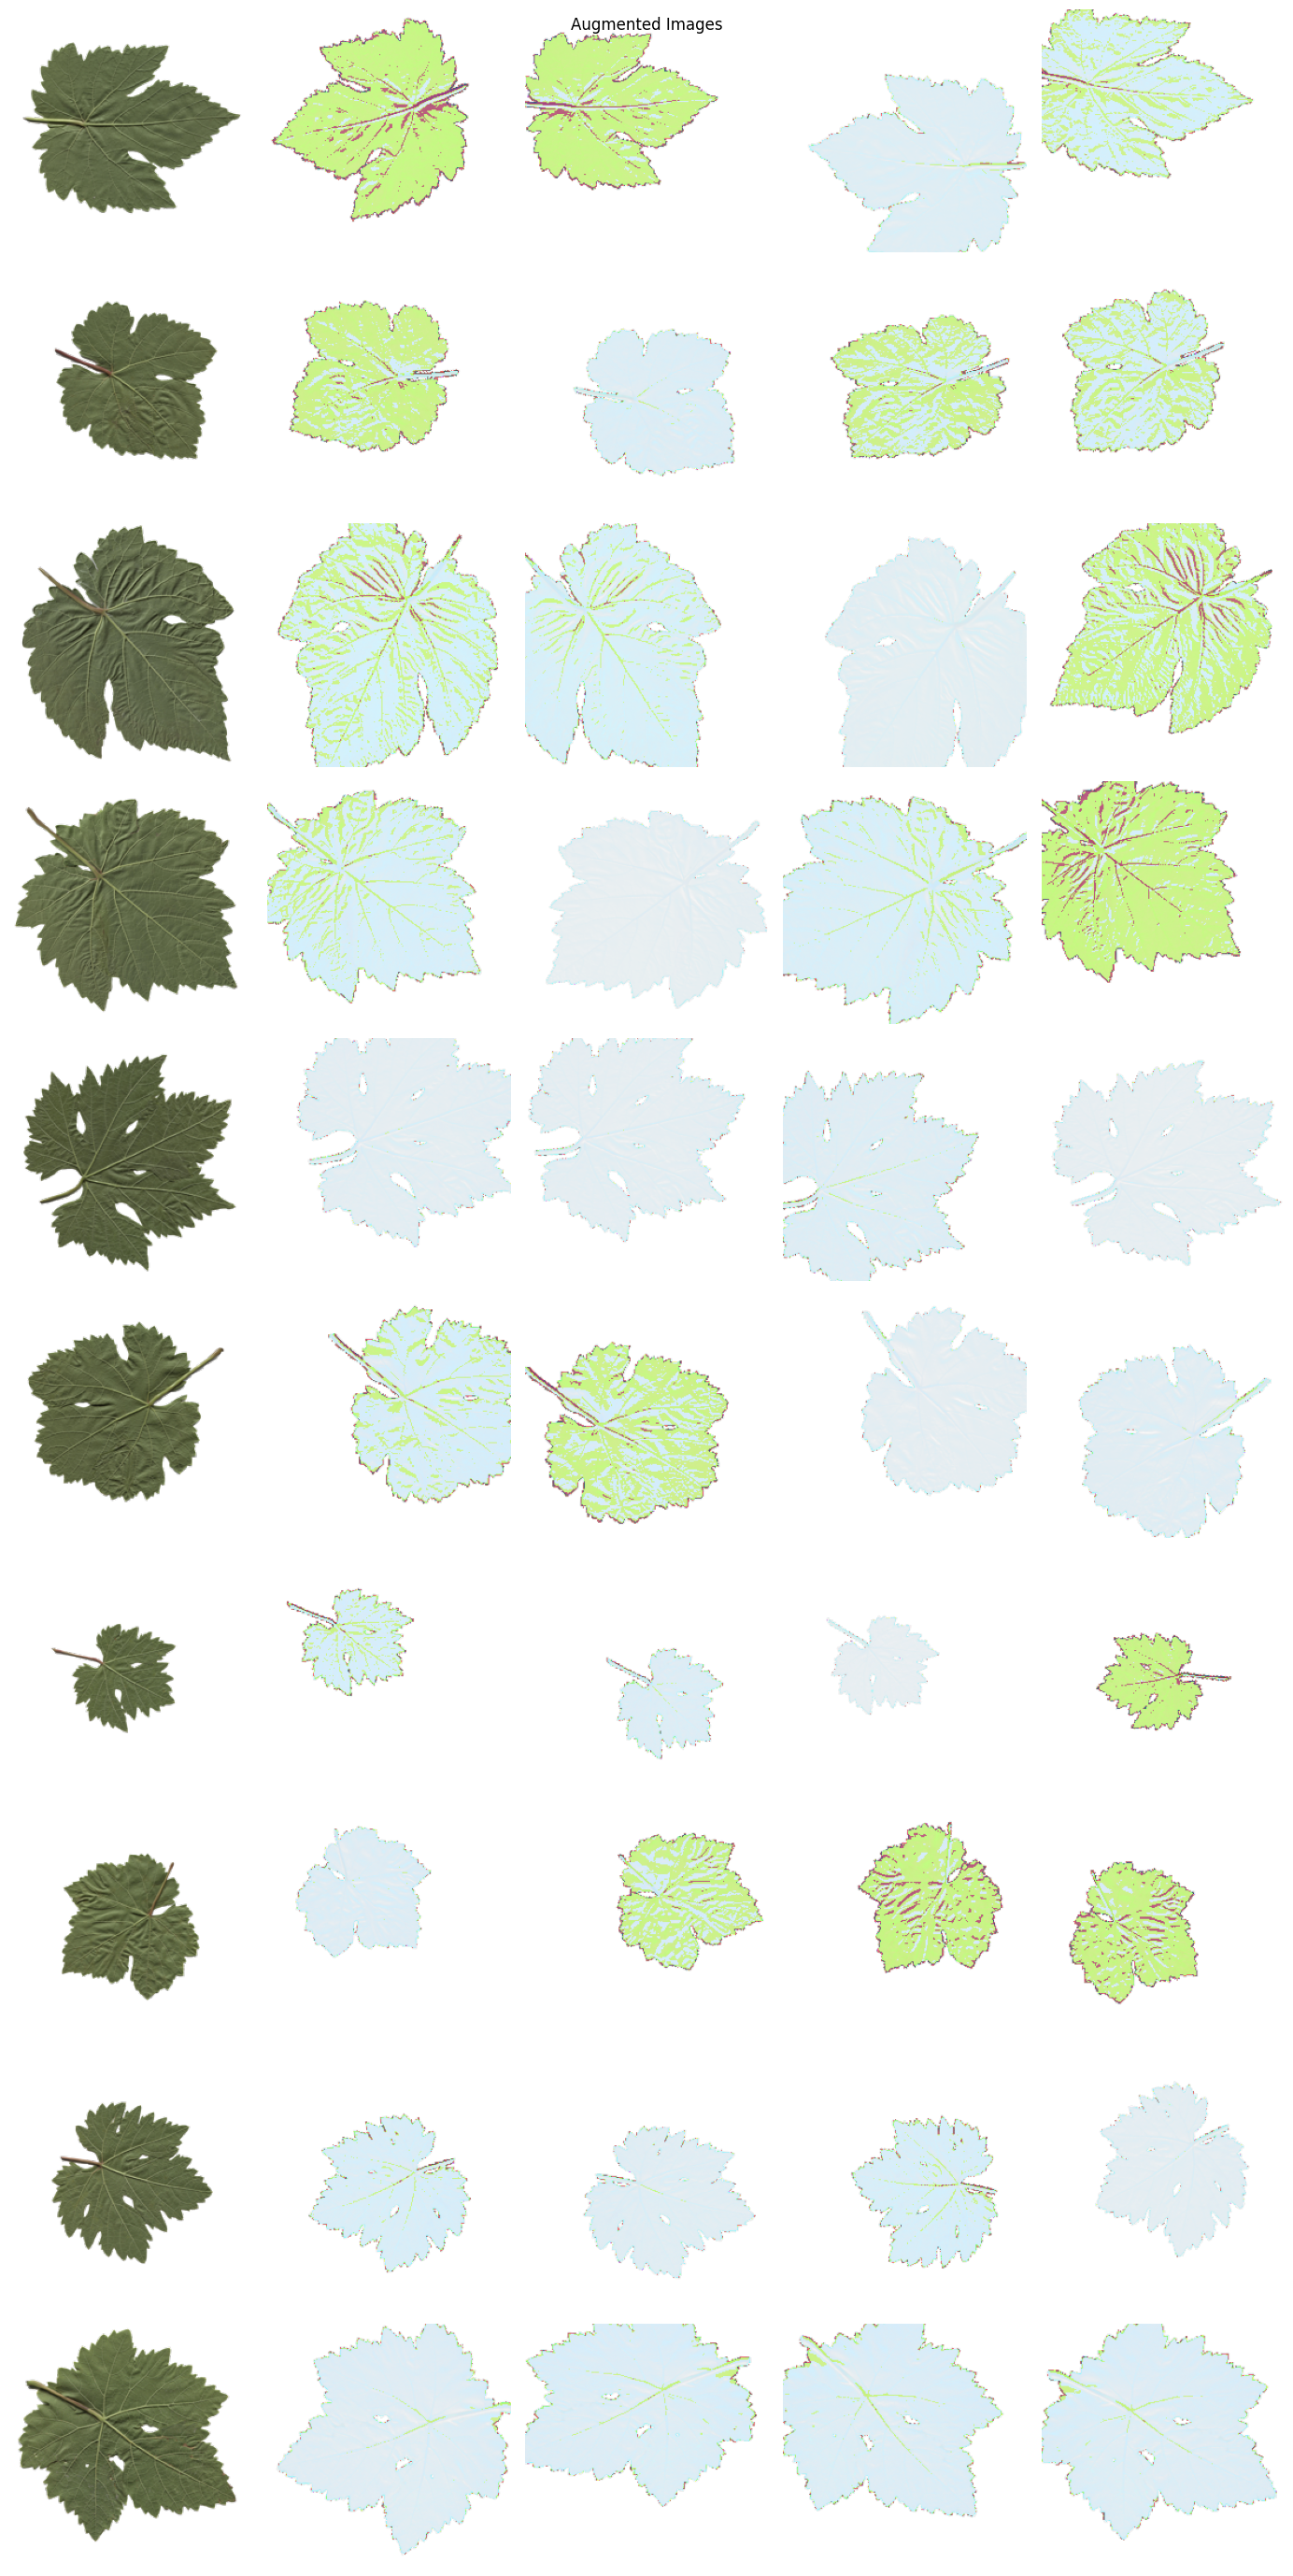

In [11]:
plot_augimages(np.random.choice(X_train, 10), resnet50_datagen)

In [14]:
# exclude the top (output) layer of the model
# initialize the model's weights with pre-trained weights from the ImageNet dataset
resnet50 = ResNet50(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in resnet50.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(resnet50.output)
predictions = Dense(5, activation='softmax')(x)

# the output tensor of the pre-trained ResNet-50 model
model_resnet50 = Model(inputs = resnet50.input, outputs = predictions)

## Model compilation

In [15]:
model_resnet50.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

## Model training

In [16]:
history_resnet50 = model_resnet50.fit(
      train_generator_resnet50,
      validation_data=val_generator_resnet50,
      epochs=20,
      verbose=2) #verbose=2 means that training progress will be displayed for each epoch, including metrics like loss and accuracy.

Epoch 1/20
10/10 - 22s - loss: 1.7008 - accuracy: 0.2219 - val_loss: 1.6031 - val_accuracy: 0.3000 - 22s/epoch - 2s/step
Epoch 2/20
10/10 - 7s - loss: 1.4715 - accuracy: 0.3844 - val_loss: 1.3413 - val_accuracy: 0.4500 - 7s/epoch - 749ms/step
Epoch 3/20
10/10 - 9s - loss: 1.3204 - accuracy: 0.4844 - val_loss: 1.2284 - val_accuracy: 0.6250 - 9s/epoch - 871ms/step
Epoch 4/20
10/10 - 8s - loss: 1.1713 - accuracy: 0.6125 - val_loss: 1.1880 - val_accuracy: 0.5625 - 8s/epoch - 849ms/step
Epoch 5/20
10/10 - 7s - loss: 1.1347 - accuracy: 0.5875 - val_loss: 1.1273 - val_accuracy: 0.5750 - 7s/epoch - 746ms/step
Epoch 6/20
10/10 - 9s - loss: 1.0342 - accuracy: 0.6375 - val_loss: 1.1030 - val_accuracy: 0.6375 - 9s/epoch - 851ms/step
Epoch 7/20
10/10 - 12s - loss: 0.9668 - accuracy: 0.6812 - val_loss: 0.9799 - val_accuracy: 0.6500 - 12s/epoch - 1s/step
Epoch 8/20
10/10 - 11s - loss: 0.9102 - accuracy: 0.6969 - val_loss: 0.8840 - val_accuracy: 0.7250 - 11s/epoch - 1s/step
Epoch 9/20
10/10 - 8s - los

# Previous approach

In [17]:
img_width = 227
img_height = 227

EPOCHS = 20
BATCH_SIZE = 32

IMAGE_SHAPE = (img_width, img_height)

In [18]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    validation_split=0.1
)

In [19]:
train_gen = datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_train, 'label': y_train}),
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical',
    shuffle=True
)

validation_gen = datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_train, 'label': y_train}),
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


test_gen = datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_test, 'label': y_test}),
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SHAPE,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 288 validated image filenames belonging to 5 classes.
Found 32 validated image filenames belonging to 5 classes.
Found 100 validated image filenames.


In [20]:
CLASSES = set(y_train)

## Inception model

In [21]:
inception_v3 = InceptionV3(include_top= False , weights= None , input_shape = (img_width , img_height , 3))

In [26]:
url = 'https://github.com/kohpangwei/influence-release/raw/master/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

weights_path = 'inception_v3_weights.h5'

response = requests.get(url)

if response.status_code == 200:
    with open(weights_path, 'wb') as f:
        f.write(response.content)
else:
    print("Nie udało się pobrać pliku.")

inception_v3.load_weights(weights_path)

In [27]:
#freezing the layers so that they are not affected by the training on the new dataset
for layer in inception_v3.layers:
    layer.trainable = False

In [28]:
last_layer = inception_v3.get_layer('mixed7') #I will put my output nodes on this layer
last_output = last_layer.output

In [29]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(100 , activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(5 , activation = 'softmax')(x)
pre_trained_model = tf.keras.models.Model(inputs = inception_v3.input , outputs = x)

In [30]:
pre_trained_model.compile(loss = tf.keras.losses.categorical_crossentropy , optimizer = tf.keras.optimizers.Adam() , metrics = ['accuracy'])

In [31]:
history_pre_trained = pre_trained_model.fit(train_gen , epochs = EPOCHS , validation_data= validation_gen)

Epoch 1/20
9/9 [==============================] - 9s 412ms/step - loss: 7.5268 - accuracy: 0.2708 - val_loss: 1.7597 - val_accuracy: 0.3750
Epoch 2/20
9/9 [==============================] - 2s 241ms/step - loss: 1.4291 - accuracy: 0.5382 - val_loss: 1.2760 - val_accuracy: 0.3438
Epoch 3/20
9/9 [==============================] - 2s 243ms/step - loss: 0.6876 - accuracy: 0.7812 - val_loss: 1.3137 - val_accuracy: 0.5000
Epoch 4/20
9/9 [==============================] - 3s 282ms/step - loss: 0.4573 - accuracy: 0.8611 - val_loss: 1.1970 - val_accuracy: 0.5625
Epoch 5/20
9/9 [==============================] - 2s 253ms/step - loss: 0.3495 - accuracy: 0.8646 - val_loss: 1.3572 - val_accuracy: 0.5625
Epoch 6/20
9/9 [==============================] - 2s 239ms/step - loss: 0.2743 - accuracy: 0.9201 - val_loss: 0.9052 - val_accuracy: 0.7188
Epoch 7/20
9/9 [==============================] - 2s 241ms/step - loss: 0.1770 - accuracy: 0.9583 - val_loss: 1.0944 - val_accuracy: 0.5625
Epoch 8/20
9/9 [====

## BASIC SEQUENTIAL MODEL

In [33]:
model = Sequential()

# Add a 2D convolutional layer with 32 filters of size 3x3 and ReLU activation function
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))

# Add a MaxPooling layer to reduce the data size
model.add(MaxPooling2D((2, 2)))

# Add another 2D convolutional layer with 64 filters of size 3x3 and ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another MaxPooling layer
model.add(MaxPooling2D((2, 2)))

# Add a 2D convolutional layer with 128 filters of size 3x3 and ReLU activation
model.add(Conv2D(128, (3, 3), activation='relu'))

# Add another MaxPooling layer
model.add(MaxPooling2D((2, 2)))

# Flatten the data into a one-dimensional array
model.add(Flatten())

# Add a dense layer with 512 units and ReLU activation
model.add(Dense(512, activation='relu'))

# Add an output layer with one neuron and a sigmoid activation function (binary classification)
model.add(Dense(len(CLASSES), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])


In [34]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=EPOCHS,
    validation_data=validation_gen,
    validation_steps=len(validation_gen)
)

Epoch 1/20
9/9 [==============================] - 8s 257ms/step - loss: 1.7606 - accuracy: 0.2083 - val_loss: 1.6460 - val_accuracy: 0.2500
Epoch 2/20
9/9 [==============================] - 2s 231ms/step - loss: 1.6108 - accuracy: 0.2326 - val_loss: 1.6174 - val_accuracy: 0.1875
Epoch 3/20
9/9 [==============================] - 2s 231ms/step - loss: 1.5520 - accuracy: 0.2812 - val_loss: 1.5951 - val_accuracy: 0.3125
Epoch 4/20
9/9 [==============================] - 2s 231ms/step - loss: 1.4894 - accuracy: 0.4410 - val_loss: 1.5665 - val_accuracy: 0.3125
Epoch 5/20
9/9 [==============================] - 2s 258ms/step - loss: 1.4098 - accuracy: 0.5243 - val_loss: 1.5394 - val_accuracy: 0.4062
Epoch 6/20
9/9 [==============================] - 3s 274ms/step - loss: 1.3168 - accuracy: 0.5417 - val_loss: 1.5410 - val_accuracy: 0.3125
Epoch 7/20
9/9 [==============================] - 2s 231ms/step - loss: 1.2138 - accuracy: 0.5451 - val_loss: 1.4819 - val_accuracy: 0.5000
Epoch 8/20
9/9 [====

In [35]:
model.save('basic_model.keras')

# Model 1

### WITH DROPOUTS, BATCH_NORM AND EARLY STOPPING

In [36]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(CLASSES), activation='softmax'))

In [ ]:
# Compile the model
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=validation_gen.n//validation_gen.batch_size

history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    callbacks=[callback],
                    verbose=1
)

In [ ]:
model.save('model1.keras')

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(CLASSES), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Model 2

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=EPOCHS,
    validation_data=validation_gen,
    validation_steps=len(validation_gen)
)